In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['CAP'],
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_CAP_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(663976, 829)
(663976, 1)
validation
(128936, 829)
(128936, 1)
test
(61376, 829)
(61376, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 829)]             0         


 dense (Dense)               (None, 1024)              849920    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1539073 (5.87 MB)


Trainable params: 1539073 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/67 [..............................] - ETA: 1:53 - loss: 0.0522 - STD: 4.1458e-04 - MAE: 0.2181

 4/67 [>.............................] - ETA: 2s - loss: 0.0312 - STD: 2.9719e-04 - MAE: 0.1345  

 5/67 [=>............................] - ETA: 2s - loss: 0.0311 - STD: 2.9102e-04 - MAE: 0.1343

 6/67 [=>............................] - ETA: 3s - loss: 0.0304 - STD: 3.0174e-04 - MAE: 0.1316

 7/67 [==>...........................] - ETA: 3s - loss: 0.0293 - STD: 3.2750e-04 - MAE: 0.1267

 8/67 [==>...........................] - ETA: 3s - loss: 0.0275 - STD: 3.6328e-04 - MAE: 0.1194

 9/67 [===>..........................] - ETA: 3s - loss: 0.0260 - STD: 4.0520e-04 - MAE: 0.1144

10/67 [===>..........................] - ETA: 3s - loss: 0.0249 - STD: 4.4769e-04 - MAE: 0.1129

11/67 [===>..........................] - ETA: 7s - loss: 0.0247 - STD: 4.8838e-04 - MAE: 0.1136

13/67 [====>.........................] - ETA: 6s - loss: 0.0238 - STD: 5.6506e-04 - MAE: 0.1150

15/67 [=====>........................] - ETA: 5s - loss: 0.0225 - STD: 6.3064e-04 - MAE: 0.1121

16/67 [======>.......................] - ETA: 5s - loss: 0.0220 - STD: 6.5881e-04 - MAE: 0.1097

17/67 [======>.......................] - ETA: 4s - loss: 0.0215 - STD: 6.8412e-04 - MAE: 0.1072

18/67 [=======>......................] - ETA: 4s - loss: 0.0211 - STD: 7.0694e-04 - MAE: 0.1050

19/67 [=======>......................] - ETA: 4s - loss: 0.0209 - STD: 7.2886e-04 - MAE: 0.1032

20/67 [=======>......................] - ETA: 4s - loss: 0.0206 - STD: 7.5173e-04 - MAE: 0.1016

21/67 [========>.....................] - ETA: 4s - loss: 0.0204 - STD: 7.7652e-04 - MAE: 0.1001

22/67 [========>.....................] - ETA: 4s - loss: 0.0201 - STD: 8.0348e-04 - MAE: 0.0986

23/67 [=========>....................] - ETA: 4s - loss: 0.0199 - STD: 8.3300e-04 - MAE: 0.0973

24/67 [=========>....................] - ETA: 3s - loss: 0.0196 - STD: 8.6529e-04 - MAE: 0.0962

25/67 [==========>...................] - ETA: 3s - loss: 0.0193 - STD: 9.0131e-04 - MAE: 0.0955

26/67 [==========>...................] - ETA: 3s - loss: 0.0191 - STD: 9.3920e-04 - MAE: 0.0951

27/67 [===========>..................] - ETA: 3s - loss: 0.0189 - STD: 9.7938e-04 - MAE: 0.0950

28/67 [===========>..................] - ETA: 3s - loss: 0.0188 - STD: 0.0010 - MAE: 0.0949    

29/67 [===========>..................] - ETA: 3s - loss: 0.0186 - STD: 0.0011 - MAE: 0.0948

30/67 [============>.................] - ETA: 3s - loss: 0.0185 - STD: 0.0011 - MAE: 0.0945

31/67 [============>.................] - ETA: 3s - loss: 0.0183 - STD: 0.0012 - MAE: 0.0941

32/67 [=============>................] - ETA: 3s - loss: 0.0181 - STD: 0.0012 - MAE: 0.0935

33/67 [=============>................] - ETA: 2s - loss: 0.0180 - STD: 0.0012 - MAE: 0.0928

34/67 [==============>...............] - ETA: 2s - loss: 0.0178 - STD: 0.0013 - MAE: 0.0921

35/67 [==============>...............] - ETA: 2s - loss: 0.0177 - STD: 0.0013 - MAE: 0.0914

36/67 [===============>..............] - ETA: 2s - loss: 0.0176 - STD: 0.0014 - MAE: 0.0907

37/67 [===============>..............] - ETA: 2s - loss: 0.0175 - STD: 0.0014 - MAE: 0.0901

38/67 [================>.............] - ETA: 2s - loss: 0.0174 - STD: 0.0015 - MAE: 0.0895

39/67 [================>.............] - ETA: 2s - loss: 0.0173 - STD: 0.0016 - MAE: 0.0890

40/67 [================>.............] - ETA: 2s - loss: 0.0172 - STD: 0.0016 - MAE: 0.0886

41/67 [=================>............] - ETA: 2s - loss: 0.0171 - STD: 0.0017 - MAE: 0.0882

42/67 [=================>............] - ETA: 2s - loss: 0.0169 - STD: 0.0018 - MAE: 0.0880

43/67 [==================>...........] - ETA: 2s - loss: 0.0169 - STD: 0.0019 - MAE: 0.0878

44/67 [==================>...........] - ETA: 1s - loss: 0.0168 - STD: 0.0020 - MAE: 0.0877

45/67 [===================>..........] - ETA: 1s - loss: 0.0167 - STD: 0.0021 - MAE: 0.0875

46/67 [===================>..........] - ETA: 1s - loss: 0.0166 - STD: 0.0022 - MAE: 0.0873

47/67 [====================>.........] - ETA: 1s - loss: 0.0165 - STD: 0.0023 - MAE: 0.0870

48/67 [====================>.........] - ETA: 1s - loss: 0.0164 - STD: 0.0025 - MAE: 0.0867

49/67 [====================>.........] - ETA: 1s - loss: 0.0163 - STD: 0.0026 - MAE: 0.0863

50/67 [=====================>........] - ETA: 1s - loss: 0.0163 - STD: 0.0027 - MAE: 0.0859

51/67 [=====================>........] - ETA: 1s - loss: 0.0162 - STD: 0.0029 - MAE: 0.0856

52/67 [======================>.......] - ETA: 1s - loss: 0.0161 - STD: 0.0031 - MAE: 0.0852

53/67 [======================>.......] - ETA: 1s - loss: 0.0160 - STD: 0.0033 - MAE: 0.0849

54/67 [=======================>......] - ETA: 1s - loss: 0.0159 - STD: 0.0035 - MAE: 0.0846

55/67 [=======================>......] - ETA: 1s - loss: 0.0159 - STD: 0.0037 - MAE: 0.0843

56/67 [========================>.....] - ETA: 0s - loss: 0.0158 - STD: 0.0040 - MAE: 0.0840

57/67 [========================>.....] - ETA: 0s - loss: 0.0157 - STD: 0.0043 - MAE: 0.0838

58/67 [========================>.....] - ETA: 0s - loss: 0.0156 - STD: 0.0046 - MAE: 0.0835

59/67 [=========================>....] - ETA: 0s - loss: 0.0155 - STD: 0.0050 - MAE: 0.0833

60/67 [=========================>....] - ETA: 0s - loss: 0.0154 - STD: 0.0054 - MAE: 0.0830

61/67 [==========================>...] - ETA: 0s - loss: 0.0153 - STD: 0.0058 - MAE: 0.0826

62/67 [==========================>...] - ETA: 0s - loss: 0.0152 - STD: 0.0062 - MAE: 0.0823

63/67 [===========================>..] - ETA: 0s - loss: 0.0151 - STD: 0.0067 - MAE: 0.0819

64/67 [===========================>..] - ETA: 0s - loss: 0.0150 - STD: 0.0073 - MAE: 0.0815

65/67 [============================>.] - ETA: 0s - loss: 0.0149 - STD: 0.0078 - MAE: 0.0811

66/67 [============================>.] - ETA: 0s - loss: 0.0148 - STD: 0.0085 - MAE: 0.0808

67/67 [==============================] - ETA: 0s - loss: 0.0147 - STD: 0.0092 - MAE: 0.0804

67/67 [==============================] - 8s 96ms/step - loss: 0.0147 - STD: 0.0092 - MAE: 0.0804 - val_loss: 0.0071 - val_STD: 0.0460 - val_MAE: 0.0545


Epoch 2/10000


 1/67 [..............................] - ETA: 7s - loss: 0.0069 - STD: 0.0596 - MAE: 0.0550

 2/67 [..............................] - ETA: 5s - loss: 0.0068 - STD: 0.0623 - MAE: 0.0546

 3/67 [>.............................] - ETA: 5s - loss: 0.0066 - STD: 0.0644 - MAE: 0.0539

 4/67 [>.............................] - ETA: 5s - loss: 0.0065 - STD: 0.0665 - MAE: 0.0535

 5/67 [=>............................] - ETA: 5s - loss: 0.0063 - STD: 0.0683 - MAE: 0.0530

 6/67 [=>............................] - ETA: 4s - loss: 0.0062 - STD: 0.0701 - MAE: 0.0526

 7/67 [==>...........................] - ETA: 4s - loss: 0.0061 - STD: 0.0716 - MAE: 0.0522

 8/67 [==>...........................] - ETA: 4s - loss: 0.0060 - STD: 0.0732 - MAE: 0.0518

 9/67 [===>..........................] - ETA: 4s - loss: 0.0060 - STD: 0.0748 - MAE: 0.0515

11/67 [===>..........................] - ETA: 4s - loss: 0.0058 - STD: 0.0777 - MAE: 0.0508

12/67 [====>.........................] - ETA: 4s - loss: 0.0057 - STD: 0.0787 - MAE: 0.0505

13/67 [====>.........................] - ETA: 4s - loss: 0.0056 - STD: 0.0794 - MAE: 0.0502

14/67 [=====>........................] - ETA: 4s - loss: 0.0056 - STD: 0.0799 - MAE: 0.0499

15/67 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0495

16/67 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0806 - MAE: 0.0493

17/67 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.0813 - MAE: 0.0491

18/67 [=======>......................] - ETA: 3s - loss: 0.0054 - STD: 0.0818 - MAE: 0.0489

19/67 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0824 - MAE: 0.0488

20/67 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0830 - MAE: 0.0486

21/67 [========>.....................] - ETA: 3s - loss: 0.0053 - STD: 0.0836 - MAE: 0.0484

22/67 [========>.....................] - ETA: 3s - loss: 0.0052 - STD: 0.0840 - MAE: 0.0483

23/67 [=========>....................] - ETA: 3s - loss: 0.0052 - STD: 0.0845 - MAE: 0.0481

24/67 [=========>....................] - ETA: 3s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0480

25/67 [==========>...................] - ETA: 3s - loss: 0.0051 - STD: 0.0855 - MAE: 0.0479

26/67 [==========>...................] - ETA: 3s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0478

27/67 [===========>..................] - ETA: 3s - loss: 0.0051 - STD: 0.0864 - MAE: 0.0477

28/67 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0868 - MAE: 0.0476

29/67 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0872 - MAE: 0.0475

30/67 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0875 - MAE: 0.0475

31/67 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0878 - MAE: 0.0474

32/67 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0878 - MAE: 0.0473

33/67 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0880 - MAE: 0.0472

34/67 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0882 - MAE: 0.0472

35/67 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0883 - MAE: 0.0471

36/67 [===============>..............] - ETA: 2s - loss: 0.0050 - STD: 0.0885 - MAE: 0.0471

37/67 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.0887 - MAE: 0.0470

38/67 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.0889 - MAE: 0.0470

39/67 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.0890 - MAE: 0.0469

40/67 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.0892 - MAE: 0.0469

41/67 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0892 - MAE: 0.0468

42/67 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0894 - MAE: 0.0468

43/67 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0895 - MAE: 0.0467

44/67 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0896 - MAE: 0.0467

45/67 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0898 - MAE: 0.0467

46/67 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0899 - MAE: 0.0466

47/67 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0900 - MAE: 0.0466

48/67 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0901 - MAE: 0.0466

49/67 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0902 - MAE: 0.0465

50/67 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0902 - MAE: 0.0465

51/67 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0904 - MAE: 0.0465

52/67 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0904 - MAE: 0.0464

53/67 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0906 - MAE: 0.0464

54/67 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0906 - MAE: 0.0464

55/67 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0907 - MAE: 0.0464

56/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0908 - MAE: 0.0463

57/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0909 - MAE: 0.0463

58/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0910 - MAE: 0.0463

59/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0911 - MAE: 0.0462

60/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0912 - MAE: 0.0462

61/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0912 - MAE: 0.0462

62/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0913 - MAE: 0.0462

63/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0913 - MAE: 0.0461

64/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0914 - MAE: 0.0461

65/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0915 - MAE: 0.0461

66/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0916 - MAE: 0.0460

67/67 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0916 - MAE: 0.0460

67/67 [==============================] - 6s 82ms/step - loss: 0.0047 - STD: 0.0916 - MAE: 0.0460 - val_loss: 0.0033 - val_STD: 0.0758 - val_MAE: 0.0388


Epoch 3/10000


 1/67 [..............................] - ETA: 7s - loss: 0.0044 - STD: 0.0939 - MAE: 0.0442

 2/67 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0949 - MAE: 0.0441

 3/67 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0960 - MAE: 0.0442

 4/67 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0967 - MAE: 0.0442

 5/67 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0966 - MAE: 0.0440

 6/67 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0966 - MAE: 0.0440

 7/67 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0965 - MAE: 0.0440

 8/67 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0968 - MAE: 0.0440

 9/67 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0971 - MAE: 0.0441

10/67 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0968 - MAE: 0.0441

11/67 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0967 - MAE: 0.0441

12/67 [====>.........................] - ETA: 4s - loss: 0.0043 - STD: 0.0963 - MAE: 0.0440

13/67 [====>.........................] - ETA: 4s - loss: 0.0043 - STD: 0.0962 - MAE: 0.0440

14/67 [=====>........................] - ETA: 4s - loss: 0.0043 - STD: 0.0962 - MAE: 0.0441

15/67 [=====>........................] - ETA: 4s - loss: 0.0043 - STD: 0.0962 - MAE: 0.0441

16/67 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0962 - MAE: 0.0441

17/67 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0961 - MAE: 0.0442

18/67 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0962 - MAE: 0.0442

19/67 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0963 - MAE: 0.0442

20/67 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0964 - MAE: 0.0442

21/67 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0965 - MAE: 0.0442

22/67 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0964 - MAE: 0.0441

23/67 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0963 - MAE: 0.0441

24/67 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0964 - MAE: 0.0440

25/67 [==========>...................] - ETA: 3s - loss: 0.0043 - STD: 0.0965 - MAE: 0.0441

26/67 [==========>...................] - ETA: 3s - loss: 0.0043 - STD: 0.0966 - MAE: 0.0441

27/67 [===========>..................] - ETA: 3s - loss: 0.0043 - STD: 0.0966 - MAE: 0.0441

28/67 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0965 - MAE: 0.0441

29/67 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0966 - MAE: 0.0441

30/67 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0966 - MAE: 0.0441

31/67 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0966 - MAE: 0.0441

33/67 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0967 - MAE: 0.0440

34/67 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0966 - MAE: 0.0440

35/67 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0967 - MAE: 0.0440

36/67 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0967 - MAE: 0.0440

37/67 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0966 - MAE: 0.0440

38/67 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.0966 - MAE: 0.0440

39/67 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.0966 - MAE: 0.0440

40/67 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.0967 - MAE: 0.0440

41/67 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0967 - MAE: 0.0440

42/67 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0968 - MAE: 0.0440

43/67 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0967 - MAE: 0.0440

44/67 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0968 - MAE: 0.0440

45/67 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0969 - MAE: 0.0440

46/67 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0969 - MAE: 0.0439

47/67 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0969 - MAE: 0.0439

48/67 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0969 - MAE: 0.0439

49/67 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0969 - MAE: 0.0439

50/67 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0969 - MAE: 0.0439

51/67 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0968 - MAE: 0.0439

52/67 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0968 - MAE: 0.0439

53/67 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0968 - MAE: 0.0439

54/67 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0968 - MAE: 0.0438

55/67 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0969 - MAE: 0.0438

56/67 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0969 - MAE: 0.0438

57/67 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0969 - MAE: 0.0438

58/67 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0970 - MAE: 0.0438

59/67 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0970 - MAE: 0.0438

60/67 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0970 - MAE: 0.0438

61/67 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0969 - MAE: 0.0437

62/67 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0969 - MAE: 0.0437

63/67 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0969 - MAE: 0.0437

64/67 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0968 - MAE: 0.0437

65/67 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0968 - MAE: 0.0437

66/67 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0968 - MAE: 0.0437

67/67 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0968 - MAE: 0.0437

67/67 [==============================] - 6s 82ms/step - loss: 0.0042 - STD: 0.0968 - MAE: 0.0437 - val_loss: 0.0032 - val_STD: 0.0805 - val_MAE: 0.0386


Epoch 4/10000


 1/67 [..............................] - ETA: 8s - loss: 0.0040 - STD: 0.0956 - MAE: 0.0427

 2/67 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0986 - MAE: 0.0425

 3/67 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0988 - MAE: 0.0427

 4/67 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0984 - MAE: 0.0428

 5/67 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0983 - MAE: 0.0429

 6/67 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0981 - MAE: 0.0430

 7/67 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0978 - MAE: 0.0429

 8/67 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0977 - MAE: 0.0428

 9/67 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0976 - MAE: 0.0427

10/67 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0976 - MAE: 0.0426

11/67 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0978 - MAE: 0.0426

12/67 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0979 - MAE: 0.0426

13/67 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0981 - MAE: 0.0426

14/67 [=====>........................] - ETA: 4s - loss: 0.0039 - STD: 0.0983 - MAE: 0.0426

15/67 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0983 - MAE: 0.0426

16/67 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0980 - MAE: 0.0425

17/67 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0982 - MAE: 0.0425

18/67 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0980 - MAE: 0.0425

19/67 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0980 - MAE: 0.0425

20/67 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0979 - MAE: 0.0424

21/67 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0979 - MAE: 0.0425

22/67 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0982 - MAE: 0.0424

23/67 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0982 - MAE: 0.0424

24/67 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0983 - MAE: 0.0424

25/67 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0984 - MAE: 0.0424

26/67 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0984 - MAE: 0.0423

27/67 [===========>..................] - ETA: 3s - loss: 0.0039 - STD: 0.0984 - MAE: 0.0423

28/67 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0984 - MAE: 0.0423

29/67 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0985 - MAE: 0.0423

30/67 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0985 - MAE: 0.0423

31/67 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0986 - MAE: 0.0423

32/67 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0987 - MAE: 0.0423

33/67 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0987 - MAE: 0.0422

34/67 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0986 - MAE: 0.0422

35/67 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0987 - MAE: 0.0422

36/67 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0987 - MAE: 0.0422

37/67 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0986 - MAE: 0.0422

38/67 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0986 - MAE: 0.0422

39/67 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0986 - MAE: 0.0422

41/67 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0985 - MAE: 0.0422

42/67 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0986 - MAE: 0.0422

43/67 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0986 - MAE: 0.0422

44/67 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0986 - MAE: 0.0422

45/67 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0988 - MAE: 0.0422

46/67 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0987 - MAE: 0.0421

47/67 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0987 - MAE: 0.0421

48/67 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0989 - MAE: 0.0421

49/67 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0988 - MAE: 0.0421

50/67 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0987 - MAE: 0.0421

51/67 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0988 - MAE: 0.0421

52/67 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0987 - MAE: 0.0421

53/67 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0987 - MAE: 0.0421

54/67 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0987 - MAE: 0.0420

55/67 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0987 - MAE: 0.0420

56/67 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0987 - MAE: 0.0420

57/67 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0987 - MAE: 0.0420

58/67 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0987 - MAE: 0.0420

59/67 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0988 - MAE: 0.0419

60/67 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0988 - MAE: 0.0419

61/67 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0987 - MAE: 0.0419

62/67 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0988 - MAE: 0.0419

63/67 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0987 - MAE: 0.0419

64/67 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0986 - MAE: 0.0419

65/67 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0987 - MAE: 0.0419

66/67 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0987 - MAE: 0.0418

67/67 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0986 - MAE: 0.0418

67/67 [==============================] - 6s 82ms/step - loss: 0.0038 - STD: 0.0986 - MAE: 0.0418 - val_loss: 0.0032 - val_STD: 0.0881 - val_MAE: 0.0377


Epoch 5/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.1051 - MAE: 0.0410

 2/67 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.1032 - MAE: 0.0407

 3/67 [>.............................] - ETA: 5s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0407

 4/67 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.1013 - MAE: 0.0407

 5/67 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.1009 - MAE: 0.0405

 6/67 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.1009 - MAE: 0.0407

 7/67 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.1015 - MAE: 0.0408

 8/67 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.1008 - MAE: 0.0407

 9/67 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.1012 - MAE: 0.0407

10/67 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.1014 - MAE: 0.0407

11/67 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.1010 - MAE: 0.0408

12/67 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.1016 - MAE: 0.0410

13/67 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.1008 - MAE: 0.0412

14/67 [=====>........................] - ETA: 4s - loss: 0.0036 - STD: 0.1007 - MAE: 0.0411

15/67 [=====>........................] - ETA: 4s - loss: 0.0036 - STD: 0.1013 - MAE: 0.0414

16/67 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.1004 - MAE: 0.0416

17/67 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.1003 - MAE: 0.0416

18/67 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.1009 - MAE: 0.0419

19/67 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.1006 - MAE: 0.0419

20/67 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.1001 - MAE: 0.0418

21/67 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.1005 - MAE: 0.0418

22/67 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.1008 - MAE: 0.0419

23/67 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.1004 - MAE: 0.0418

24/67 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.1002 - MAE: 0.0418

25/67 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.1004 - MAE: 0.0418

26/67 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.1004 - MAE: 0.0417

27/67 [===========>..................] - ETA: 3s - loss: 0.0037 - STD: 0.1002 - MAE: 0.0417

28/67 [===========>..................] - ETA: 3s - loss: 0.0037 - STD: 0.1002 - MAE: 0.0416

29/67 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.1004 - MAE: 0.0416

30/67 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.1003 - MAE: 0.0416

31/67 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.1001 - MAE: 0.0415

32/67 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.1001 - MAE: 0.0415

33/67 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.1002 - MAE: 0.0415

34/67 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.1001 - MAE: 0.0414

35/67 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.1000 - MAE: 0.0414

36/67 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.1000 - MAE: 0.0414

37/67 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.1000 - MAE: 0.0414

38/67 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0413

39/67 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0413

40/67 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0413

41/67 [=================>............] - ETA: 2s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0413

42/67 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0998 - MAE: 0.0412

43/67 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0998 - MAE: 0.0412

44/67 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0412

45/67 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0412

46/67 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0998 - MAE: 0.0411

47/67 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0411

48/67 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0411

49/67 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0411

50/67 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0998 - MAE: 0.0411

51/67 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0998 - MAE: 0.0411

52/67 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0998 - MAE: 0.0410

53/67 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0998 - MAE: 0.0410

54/67 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0998 - MAE: 0.0410

55/67 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0998 - MAE: 0.0410

56/67 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0410

57/67 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0998 - MAE: 0.0409

58/67 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0998 - MAE: 0.0409

59/67 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0409

60/67 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0409

61/67 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0409

63/67 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.1000 - MAE: 0.0408

64/67 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.1000 - MAE: 0.0408

65/67 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.1000 - MAE: 0.0408

66/67 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.1001 - MAE: 0.0408

67/67 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.1001 - MAE: 0.0408

67/67 [==============================] - 6s 84ms/step - loss: 0.0036 - STD: 0.1001 - MAE: 0.0408 - val_loss: 0.0031 - val_STD: 0.0894 - val_MAE: 0.0377


Epoch 6/10000


 1/67 [..............................] - ETA: 8s - loss: 0.0035 - STD: 0.1021 - MAE: 0.0401

 2/67 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.1018 - MAE: 0.0400

 3/67 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0397

 4/67 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.1017 - MAE: 0.0398

 5/67 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0398

 6/67 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0399

 7/67 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0398

 8/67 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0398

 9/67 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0397

10/67 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0397

11/67 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0398

12/67 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.1006 - MAE: 0.0397

13/67 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0398

14/67 [=====>........................] - ETA: 4s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0400

15/67 [=====>........................] - ETA: 4s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0400

16/67 [======>.......................] - ETA: 4s - loss: 0.0034 - STD: 0.1015 - MAE: 0.0401

17/67 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.1011 - MAE: 0.0403

18/67 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.1009 - MAE: 0.0402

19/67 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.1014 - MAE: 0.0404

20/67 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0405

21/67 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.1009 - MAE: 0.0405

22/67 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.1014 - MAE: 0.0408

23/67 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.1012 - MAE: 0.0408

24/67 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0409

25/67 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.1015 - MAE: 0.0411

26/67 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.1016 - MAE: 0.0410

27/67 [===========>..................] - ETA: 3s - loss: 0.0036 - STD: 0.1012 - MAE: 0.0411

28/67 [===========>..................] - ETA: 3s - loss: 0.0036 - STD: 0.1012 - MAE: 0.0410

29/67 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.1014 - MAE: 0.0411

30/67 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.1012 - MAE: 0.0411

31/67 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.1010 - MAE: 0.0411

32/67 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.1011 - MAE: 0.0411

33/67 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.1012 - MAE: 0.0410

34/67 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.1011 - MAE: 0.0410

36/67 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.1011 - MAE: 0.0409

37/67 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.1012 - MAE: 0.0409

38/67 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.1011 - MAE: 0.0409

39/67 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.1011 - MAE: 0.0408

40/67 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.1011 - MAE: 0.0408

41/67 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.1011 - MAE: 0.0408

42/67 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0407

43/67 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0407

44/67 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.1011 - MAE: 0.0407

45/67 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0407

46/67 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0406

47/67 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0406

48/67 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0406

49/67 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0406

50/67 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0406

51/67 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0406

52/67 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0405

53/67 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0405

54/67 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.1009 - MAE: 0.0405

55/67 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.1009 - MAE: 0.0405

56/67 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.1009 - MAE: 0.0404

57/67 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0404

58/67 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0404

59/67 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.1009 - MAE: 0.0404

60/67 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0404

61/67 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0404

62/67 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0404

63/67 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0404

64/67 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0404

65/67 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0404

66/67 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.1009 - MAE: 0.0403

67/67 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0403

67/67 [==============================] - 5s 81ms/step - loss: 0.0035 - STD: 0.1008 - MAE: 0.0403 - val_loss: 0.0032 - val_STD: 0.0862 - val_MAE: 0.0390


Epoch 7/10000


 1/67 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0980 - MAE: 0.0395

 2/67 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0397

 3/67 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0394

 4/67 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0394

 5/67 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0393

 6/67 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.1026 - MAE: 0.0391

 7/67 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.1024 - MAE: 0.0392

 8/67 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.1022 - MAE: 0.0393

 9/67 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.1022 - MAE: 0.0393

10/67 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.1024 - MAE: 0.0393

11/67 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0393

12/67 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0393

13/67 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.1018 - MAE: 0.0392

14/67 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0392

15/67 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.1018 - MAE: 0.0393

16/67 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0392

17/67 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.1018 - MAE: 0.0393

18/67 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.1018 - MAE: 0.0393

19/67 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0393

20/67 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0393

21/67 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0392

23/67 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0392

24/67 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0392

25/67 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0392

26/67 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0392

27/67 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0392

28/67 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0392

29/67 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0392

30/67 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0392

31/67 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0393

32/67 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0393

33/67 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0393

34/67 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0393

35/67 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0393

36/67 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0393

37/67 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0394

38/67 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0394

39/67 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0394

40/67 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0394

41/67 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0394

42/67 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0394

43/67 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0395

44/67 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0395

45/67 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0395

46/67 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0395

47/67 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0395

48/67 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0394

49/67 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0394

50/67 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0394

51/67 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0394

52/67 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0394

53/67 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0394

54/67 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0394

55/67 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0394

56/67 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0394

57/67 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0394

58/67 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0394

59/67 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0394

60/67 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0394

61/67 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0394

62/67 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0394

63/67 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0394

64/67 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0394

65/67 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0394

66/67 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0393

67/67 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0393

67/67 [==============================] - 6s 82ms/step - loss: 0.0033 - STD: 0.1016 - MAE: 0.0393 - val_loss: 0.0031 - val_STD: 0.0892 - val_MAE: 0.0373


Epoch 8/10000


 1/67 [..............................] - ETA: 8s - loss: 0.0032 - STD: 0.1035 - MAE: 0.0389

 2/67 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.1018 - MAE: 0.0388

 3/67 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0389

 4/67 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0389

 5/67 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0389

 6/67 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.1029 - MAE: 0.0389

 7/67 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.1028 - MAE: 0.0388

 8/67 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.1028 - MAE: 0.0388

 9/67 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0387

10/67 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.1018 - MAE: 0.0386

11/67 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.1018 - MAE: 0.0387

12/67 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0387

13/67 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.1018 - MAE: 0.0387

14/67 [=====>........................] - ETA: 4s - loss: 0.0032 - STD: 0.1018 - MAE: 0.0387

15/67 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0388

16/67 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0389

17/67 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0389

18/67 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0389

19/67 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0389

21/67 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0390

22/67 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0390

23/67 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0390

24/67 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0390

25/67 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0389

26/67 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0389

27/67 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0389

28/67 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0389

29/67 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0389

30/67 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0389

31/67 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0389

32/67 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0389

33/67 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0388

34/67 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0388

35/67 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0388

36/67 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0388

37/67 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0388

38/67 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0388

39/67 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0388

40/67 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0388

41/67 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0388

42/67 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0388

43/67 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0388

44/67 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0388

45/67 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0388

46/67 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0388

47/67 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0388

48/67 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0388

49/67 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0388

50/67 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0387

51/67 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0388

52/67 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0388

53/67 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0388

54/67 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0387

55/67 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0387

56/67 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0387

57/67 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0387

58/67 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0387

59/67 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0387

60/67 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0387

61/67 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0387

62/67 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0387

63/67 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0387

64/67 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0387

65/67 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0387

66/67 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0387

67/67 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0387

67/67 [==============================] - 5s 67ms/step - loss: 0.0032 - STD: 0.1023 - MAE: 0.0387 - val_loss: 0.0031 - val_STD: 0.0896 - val_MAE: 0.0386


Epoch 9/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.1037 - MAE: 0.0388

 2/67 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.1052 - MAE: 0.0387

 3/67 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.1038 - MAE: 0.0385

 4/67 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.1033 - MAE: 0.0385

 5/67 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.1030 - MAE: 0.0384

 6/67 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0383

 7/67 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0382

 8/67 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.1020 - MAE: 0.0382

 9/67 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0382

10/67 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.1017 - MAE: 0.0382

11/67 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.1020 - MAE: 0.0382

12/67 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.1016 - MAE: 0.0383

13/67 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0385

14/67 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.1015 - MAE: 0.0388

15/67 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0390

16/67 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.1017 - MAE: 0.0391

17/67 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.1017 - MAE: 0.0391

18/67 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.1018 - MAE: 0.0391

19/67 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.1016 - MAE: 0.0390

20/67 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0391

21/67 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.1018 - MAE: 0.0391

22/67 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0390

23/67 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0390

24/67 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0390

25/67 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0389

26/67 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0389

27/67 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0388

28/67 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0388

29/67 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0388

30/67 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0388

31/67 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0388

32/67 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0388

33/67 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0388

34/67 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0388

35/67 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0388

36/67 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0388

37/67 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0388

38/67 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0388

39/67 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0388

40/67 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0387

41/67 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0387

42/67 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0387

43/67 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0387

44/67 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0387

45/67 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0386

46/67 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0386

47/67 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0386

49/67 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0386

50/67 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0386

51/67 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0386

52/67 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0386

53/67 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0386

54/67 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0386

55/67 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0385

56/67 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0385

57/67 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0385

58/67 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0385

59/67 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0385

60/67 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0385

61/67 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0385

62/67 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0385

63/67 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0385

64/67 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0385

65/67 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0385

66/67 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0385

67/67 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0385

67/67 [==============================] - 4s 58ms/step - loss: 0.0031 - STD: 0.1026 - MAE: 0.0385 - val_loss: 0.0032 - val_STD: 0.0867 - val_MAE: 0.0395


Epoch 10/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0984 - MAE: 0.0378

 2/67 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0383

 3/67 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.1008 - MAE: 0.0383

 4/67 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0385

 5/67 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0387

 6/67 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0388

 7/67 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0389

 8/67 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0391

 9/67 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0390

10/67 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0389

11/67 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0388

12/67 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0389

13/67 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.1030 - MAE: 0.0389

14/67 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0390

15/67 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.1028 - MAE: 0.0390

16/67 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0389

17/67 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0390

18/67 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0392

19/67 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0392

20/67 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0392

21/67 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0392

22/67 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0393

23/67 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0393

24/67 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0393

25/67 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0393

26/67 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0393

27/67 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0393

28/67 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0393

29/67 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0393

30/67 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0392

31/67 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0392

32/67 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0392

33/67 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0392

34/67 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0391

35/67 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0391

36/67 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0391

37/67 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0391

38/67 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0391

39/67 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0391

40/67 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0391

41/67 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0391

42/67 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0391

43/67 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0391

44/67 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0391

45/67 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0391

46/67 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0391

47/67 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0391

48/67 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0391

49/67 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0390

50/67 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0390

51/67 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0390

52/67 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0390

53/67 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0390

54/67 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0390

55/67 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0389

56/67 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0389

57/67 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0390

58/67 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0389

59/67 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0389

60/67 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0389

61/67 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0389

62/67 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0389

63/67 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0389

64/67 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0389

65/67 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0389

66/67 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0389

67/67 [==============================] - 4s 58ms/step - loss: 0.0032 - STD: 0.1023 - MAE: 0.0389 - val_loss: 0.0031 - val_STD: 0.0923 - val_MAE: 0.0368


Epoch 11/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.1048 - MAE: 0.0393

 2/67 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0994 - MAE: 0.0393

 3/67 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.1006 - MAE: 0.0389

 4/67 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.1018 - MAE: 0.0391

 5/67 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.1012 - MAE: 0.0396

 6/67 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.1017 - MAE: 0.0393

 7/67 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0394

 8/67 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.1015 - MAE: 0.0394

 9/67 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.1015 - MAE: 0.0391

10/67 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0392

11/67 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.1013 - MAE: 0.0393

12/67 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.1017 - MAE: 0.0392

13/67 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0393

14/67 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0394

15/67 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0393

16/67 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0393

17/67 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0393

18/67 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0391

19/67 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0392

20/67 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0392

21/67 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.1017 - MAE: 0.0391

22/67 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0391

23/67 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0391

24/67 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0391

25/67 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0391

26/67 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0390

27/67 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0390

28/67 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0390

29/67 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0389

30/67 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0389

31/67 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0388

32/67 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0388

33/67 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0387

34/67 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0387

35/67 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0386

36/67 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0386

37/67 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0386

38/67 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0386

39/67 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0386

40/67 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0385

41/67 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0385

42/67 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0385

43/67 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0385

44/67 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0385

45/67 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0384

46/67 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0384

47/67 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0384

48/67 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0384

49/67 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0384

50/67 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0384

52/67 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0383

53/67 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0383

54/67 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0383

55/67 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0383

56/67 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0383

57/67 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0383

58/67 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0383

59/67 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0383

60/67 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0383

61/67 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0383

62/67 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0383

63/67 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1029 - MAE: 0.0383

64/67 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0383

65/67 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0383

66/67 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0383

67/67 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0383

67/67 [==============================] - 4s 58ms/step - loss: 0.0031 - STD: 0.1027 - MAE: 0.0383 - val_loss: 0.0030 - val_STD: 0.0914 - val_MAE: 0.0362


Epoch 12/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.1068 - MAE: 0.0377

 2/67 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.1068 - MAE: 0.0390

 3/67 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.1033 - MAE: 0.0403

 4/67 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.1048 - MAE: 0.0401

 5/67 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.1052 - MAE: 0.0399

 6/67 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.1038 - MAE: 0.0404

 7/67 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.1043 - MAE: 0.0401

 8/67 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.1045 - MAE: 0.0399

 9/67 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.1034 - MAE: 0.0400

10/67 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.1030 - MAE: 0.0398

11/67 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.1033 - MAE: 0.0399

12/67 [====>.........................] - ETA: 2s - loss: 0.0033 - STD: 0.1027 - MAE: 0.0400

13/67 [====>.........................] - ETA: 2s - loss: 0.0033 - STD: 0.1029 - MAE: 0.0398

14/67 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.1032 - MAE: 0.0399

15/67 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.1029 - MAE: 0.0399

16/67 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.1028 - MAE: 0.0398

17/67 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.1032 - MAE: 0.0400

18/67 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.1029 - MAE: 0.0399

19/67 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.1024 - MAE: 0.0397

20/67 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.1026 - MAE: 0.0398

21/67 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.1026 - MAE: 0.0397

22/67 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.1023 - MAE: 0.0397

23/67 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0396

24/67 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0395

25/67 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0394

26/67 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0393

27/67 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0392

28/67 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0392

29/67 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0391

30/67 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0390

31/67 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0390

32/67 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0389

33/67 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0389

34/67 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0388

35/67 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0388

36/67 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0387

37/67 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0387

38/67 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0387

39/67 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0386

40/67 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0386

41/67 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0386

42/67 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0386

43/67 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0386

44/67 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0386

45/67 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0385

46/67 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0385

47/67 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0385

48/67 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0385

49/67 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0384

50/67 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0384

51/67 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0384

52/67 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0384

53/67 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0384

54/67 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0384

55/67 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0383

56/67 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0383

57/67 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0383

58/67 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0383

59/67 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0383

60/67 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0383

61/67 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0383

62/67 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0383

63/67 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0382

64/67 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0382

65/67 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0382

66/67 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0382

67/67 [==============================] - 4s 57ms/step - loss: 0.0031 - STD: 0.1028 - MAE: 0.0382 - val_loss: 0.0030 - val_STD: 0.0876 - val_MAE: 0.0379


Epoch 13/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0999 - MAE: 0.0373

 2/67 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.1009 - MAE: 0.0374

 3/67 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.1019 - MAE: 0.0373

 4/67 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.1014 - MAE: 0.0375

 5/67 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0375

 6/67 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0374

 7/67 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0375

 8/67 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.1033 - MAE: 0.0376

 9/67 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0376

10/67 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0375

11/67 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0374

12/67 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.1022 - MAE: 0.0374

13/67 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0374

14/67 [=====>........................] - ETA: 2s - loss: 0.0029 - STD: 0.1024 - MAE: 0.0374

15/67 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0374

16/67 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0374

17/67 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0374

18/67 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0374

19/67 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0374

20/67 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0374

21/67 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0374

22/67 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0374

23/67 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.1033 - MAE: 0.0374

24/67 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.1033 - MAE: 0.0374

25/67 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0374

26/67 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0373

27/67 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0374

28/67 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0374

29/67 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0374

30/67 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0374

31/67 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.1034 - MAE: 0.0374

32/67 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.1035 - MAE: 0.0374

33/67 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.1035 - MAE: 0.0374

34/67 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.1034 - MAE: 0.0374

35/67 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.1035 - MAE: 0.0374

36/67 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.1034 - MAE: 0.0374

37/67 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0374

38/67 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0374

39/67 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0374

40/67 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.1035 - MAE: 0.0374

41/67 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0374

42/67 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0374

43/67 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0374

44/67 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0374

45/67 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0374

46/67 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0374

47/67 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0374

48/67 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0374

49/67 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0374

50/67 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0374

51/67 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0374

52/67 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0374

53/67 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0374

54/67 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0373

55/67 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0374

56/67 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0374

57/67 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0374

58/67 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0374

60/67 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0374

61/67 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1035 - MAE: 0.0375

62/67 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1035 - MAE: 0.0375

63/67 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1035 - MAE: 0.0375

64/67 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1035 - MAE: 0.0375

65/67 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1034 - MAE: 0.0375

66/67 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1035 - MAE: 0.0375

67/67 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1035 - MAE: 0.0375

67/67 [==============================] - 4s 58ms/step - loss: 0.0030 - STD: 0.1035 - MAE: 0.0375 - val_loss: 0.0030 - val_STD: 0.0889 - val_MAE: 0.0375


Epoch 14/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0994 - MAE: 0.0371

 2/67 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.1038 - MAE: 0.0380

 3/67 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.1015 - MAE: 0.0379

 4/67 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.1020 - MAE: 0.0377

 5/67 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0375

 6/67 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0375

 8/67 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.1042 - MAE: 0.0373

 9/67 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.1037 - MAE: 0.0374

10/67 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.1037 - MAE: 0.0375

11/67 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0374

12/67 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0374

13/67 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.1034 - MAE: 0.0377

14/67 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0380

15/67 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0379

16/67 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.1033 - MAE: 0.0379

17/67 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0381

18/67 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0381

19/67 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0380

20/67 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0381

21/67 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.1033 - MAE: 0.0381

22/67 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0381

23/67 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0380

24/67 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.1033 - MAE: 0.0380

25/67 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0380

26/67 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0380

27/67 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0380

28/67 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0380

29/67 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0380

30/67 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0380

31/67 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0380

32/67 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0380

33/67 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0380

34/67 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0379

35/67 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0380

36/67 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0379

37/67 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0380

38/67 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0379

39/67 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0379

40/67 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0379

41/67 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0379

42/67 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0378

43/67 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0378

44/67 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0378

45/67 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0378

46/67 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0378

47/67 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0378

48/67 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0378

49/67 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0378

50/67 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0378

51/67 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0378

52/67 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0378

53/67 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0378

54/67 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0378

55/67 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0378

56/67 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0378

57/67 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0378

58/67 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0378

59/67 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0377

60/67 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0377

61/67 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0377

62/67 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0377

63/67 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0377

64/67 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0377

65/67 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0377

66/67 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0377

67/67 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0377

67/67 [==============================] - 4s 59ms/step - loss: 0.0030 - STD: 0.1031 - MAE: 0.0377 - val_loss: 0.0029 - val_STD: 0.0914 - val_MAE: 0.0361


Epoch 15/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.1055 - MAE: 0.0379

 2/67 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.1063 - MAE: 0.0379

 3/67 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.1047 - MAE: 0.0375

 4/67 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.1049 - MAE: 0.0374

 5/67 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.1045 - MAE: 0.0372

 6/67 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0371

 7/67 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0372

 8/67 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0371

 9/67 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0371

10/67 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0370

11/67 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0371

12/67 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0372

13/67 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0373

14/67 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0372

15/67 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0372

16/67 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0373

17/67 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0374

19/67 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0373

20/67 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0373

21/67 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0374

22/67 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.1042 - MAE: 0.0374

23/67 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0374

24/67 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0373

25/67 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.1042 - MAE: 0.0373

26/67 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0374

27/67 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.1042 - MAE: 0.0374

28/67 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0373

29/67 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0374

30/67 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0374

31/67 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0374

32/67 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0373

33/67 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0373

34/67 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0374

35/67 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0374

36/67 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0374

38/67 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0373

39/67 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0373

40/67 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0373

41/67 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0373

42/67 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0373

43/67 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0373

44/67 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0372

45/67 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0373

46/67 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0372

47/67 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0372

48/67 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0372

49/67 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0372

50/67 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0372

51/67 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0372

52/67 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0371

53/67 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0371

54/67 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0371

55/67 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0371

56/67 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0371

57/67 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0371

58/67 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0371

59/67 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0371

60/67 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0371

61/67 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0371

62/67 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0371

63/67 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0371

64/67 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0371

65/67 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0370

66/67 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0370

67/67 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0370

67/67 [==============================] - 4s 60ms/step - loss: 0.0029 - STD: 0.1037 - MAE: 0.0370 - val_loss: 0.0030 - val_STD: 0.0923 - val_MAE: 0.0361


Epoch 16/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0364

 2/67 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.1036 - MAE: 0.0368

 3/67 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.1042 - MAE: 0.0371

 4/67 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0373

 5/67 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.1044 - MAE: 0.0374

 6/67 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0372

 7/67 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0371

 8/67 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0371

 9/67 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0370

10/67 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0370

11/67 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0369

12/67 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0368

13/67 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.1042 - MAE: 0.0369

14/67 [=====>........................] - ETA: 2s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0369

15/67 [=====>........................] - ETA: 2s - loss: 0.0029 - STD: 0.1042 - MAE: 0.0369

16/67 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0370

17/67 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.1042 - MAE: 0.0370

18/67 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0371

19/67 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0371

20/67 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0371

21/67 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0371

22/67 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0371

23/67 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0372

24/67 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0372

25/67 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0371

26/67 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0371

27/67 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0371

28/67 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0371

29/67 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0371

30/67 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0371

31/67 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0370

32/67 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0370

33/67 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0370

34/67 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0370

35/67 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0370

36/67 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0370

37/67 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0370

38/67 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0370

39/67 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0370

40/67 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0371

41/67 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0371

42/67 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0370

43/67 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0370

44/67 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0370

45/67 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0371

46/67 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0371

47/67 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0371

48/67 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0371

49/67 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0371

50/67 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0371

51/67 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0371

52/67 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0371

53/67 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0371

54/67 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0371

55/67 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0371

56/67 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0371

57/67 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0372

59/67 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0372

60/67 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0372

61/67 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0372

63/67 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0372

64/67 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0372

65/67 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0372

67/67 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0371

67/67 [==============================] - 4s 57ms/step - loss: 0.0029 - STD: 0.1038 - MAE: 0.0371 - val_loss: 0.0028 - val_STD: 0.0899 - val_MAE: 0.0355


Epoch 17/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0355

 2/67 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.1013 - MAE: 0.0356

 3/67 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0361

 4/67 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0364

 5/67 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.1049 - MAE: 0.0365

 6/67 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.1051 - MAE: 0.0366

 7/67 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0369

 8/67 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.1046 - MAE: 0.0374

 9/67 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0372

10/67 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0371

11/67 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.1043 - MAE: 0.0374

12/67 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.1036 - MAE: 0.0378

13/67 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.1043 - MAE: 0.0379

14/67 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.1042 - MAE: 0.0378

15/67 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.1038 - MAE: 0.0377

16/67 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.1039 - MAE: 0.0378

17/67 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0377

18/67 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0376

19/67 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0376

20/67 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0376

21/67 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0376

22/67 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0376

23/67 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0376

24/67 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0376

25/67 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0375

26/67 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0375

27/67 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0376

28/67 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0376

29/67 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0376

30/67 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0376

31/67 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0376

32/67 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0376

33/67 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0376

34/67 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.1035 - MAE: 0.0377

35/67 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.1037 - MAE: 0.0377

36/67 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.1037 - MAE: 0.0376

37/67 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.1037 - MAE: 0.0376

38/67 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.1038 - MAE: 0.0376

39/67 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.1037 - MAE: 0.0376

40/67 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.1037 - MAE: 0.0376

41/67 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.1038 - MAE: 0.0376

42/67 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.1036 - MAE: 0.0376

43/67 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.1036 - MAE: 0.0376

44/67 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0376

45/67 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0375

46/67 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0375

48/67 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0375

50/67 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0375

51/67 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0374

52/67 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0374

53/67 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0374

54/67 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0374

55/67 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0374

56/67 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0374

57/67 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0373

58/67 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0373

59/67 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0373

60/67 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0373

62/67 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0373

63/67 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0372

64/67 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0372

65/67 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0372

66/67 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0372

67/67 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0372

67/67 [==============================] - 4s 63ms/step - loss: 0.0029 - STD: 0.1036 - MAE: 0.0372 - val_loss: 0.0029 - val_STD: 0.0931 - val_MAE: 0.0360


Epoch 18/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.1058 - MAE: 0.0359

 2/67 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0359

 3/67 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0362

 4/67 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0364

 5/67 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0365

 7/67 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0366

 8/67 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0369

 9/67 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0371

10/67 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0370

11/67 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0369

12/67 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0369

13/67 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0371

14/67 [=====>........................] - ETA: 2s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0372

15/67 [=====>........................] - ETA: 2s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0372

16/67 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0371

17/67 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.1043 - MAE: 0.0372

18/67 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0373

19/67 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0372

21/67 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0372

22/67 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0372

23/67 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0371

24/67 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0371

25/67 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.1043 - MAE: 0.0371

26/67 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.1042 - MAE: 0.0371

27/67 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.1042 - MAE: 0.0371

28/67 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.1044 - MAE: 0.0372

29/67 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.1042 - MAE: 0.0373

30/67 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.1042 - MAE: 0.0372

31/67 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.1044 - MAE: 0.0373

32/67 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0373

33/67 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1042 - MAE: 0.0373

34/67 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1043 - MAE: 0.0373

35/67 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0373

36/67 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0373

37/67 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0373

38/67 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0373

39/67 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0373

40/67 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0373

41/67 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0373

42/67 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0373

43/67 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0372

44/67 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0372

45/67 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0373

46/67 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0372

47/67 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0372

48/67 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0372

49/67 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0372

50/67 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0372

51/67 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0372

52/67 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0372

53/67 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0372

54/67 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0372

55/67 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0372

56/67 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0371

57/67 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0371

58/67 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0371

59/67 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0371

60/67 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0371

61/67 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0371

62/67 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0371

63/67 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0371

64/67 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0370

65/67 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0370

66/67 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0370

67/67 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0370

67/67 [==============================] - 4s 63ms/step - loss: 0.0029 - STD: 0.1038 - MAE: 0.0370 - val_loss: 0.0029 - val_STD: 0.0882 - val_MAE: 0.0371


Epoch 19/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0997 - MAE: 0.0372

 2/67 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.1044 - MAE: 0.0369

 3/67 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0367

 4/67 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0367

 5/67 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.1043 - MAE: 0.0367

 6/67 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0366

 7/67 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0365

 8/67 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0365

 9/67 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0366

10/67 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0366

11/67 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0365

12/67 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0365

13/67 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0365

14/67 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0365

15/67 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0365

16/67 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0365

17/67 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0365

19/67 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0365

20/67 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0365

21/67 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0365

22/67 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0365

23/67 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0364

24/67 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0365

25/67 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0365

26/67 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0366

27/67 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0367

28/67 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0366

29/67 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0367

30/67 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0367

31/67 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0368

32/67 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0368

33/67 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0368

34/67 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0368

35/67 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0368

36/67 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0367

37/67 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0368

38/67 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0369

39/67 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0369

40/67 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0369

41/67 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0369

42/67 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0368

43/67 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0368

44/67 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0368

45/67 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0368

46/67 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0368

47/67 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0368

48/67 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0368

49/67 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0367

50/67 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0367

51/67 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0367

52/67 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0367

53/67 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0367

54/67 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0367

55/67 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0367

56/67 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0366

57/67 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0366

58/67 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0366

59/67 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0366

60/67 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0366

61/67 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0366

62/67 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0366

63/67 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0366

64/67 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0366

65/67 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0366

66/67 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0366

67/67 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0366

67/67 [==============================] - 4s 64ms/step - loss: 0.0028 - STD: 0.1041 - MAE: 0.0366 - val_loss: 0.0030 - val_STD: 0.0931 - val_MAE: 0.0365


Epoch 20/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.1069 - MAE: 0.0371

 2/67 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0376

 3/67 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.1058 - MAE: 0.0374

 4/67 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.1055 - MAE: 0.0373

 5/67 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.1055 - MAE: 0.0372

 6/67 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.1050 - MAE: 0.0370

 7/67 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.1047 - MAE: 0.0368

 8/67 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0367

 9/67 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0366

10/67 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0366

11/67 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0366

12/67 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0366

13/67 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0366

14/67 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0366

15/67 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0365

16/67 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0365

17/67 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0365

18/67 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0365

19/67 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0367

20/67 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0368

21/67 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0368

22/67 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0368

23/67 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0368

24/67 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0368

25/67 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0369

26/67 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0368

27/67 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0368

28/67 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0368

29/67 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0368

31/67 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0367

32/67 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0367

33/67 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0367

34/67 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0367

35/67 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0366

36/67 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0367

37/67 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0367

38/67 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0367

39/67 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0366

40/67 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0366

41/67 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0366

42/67 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0366

43/67 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0366

44/67 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0366

45/67 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0366

46/67 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0365

47/67 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0365

48/67 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0365

49/67 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0365

50/67 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0365

51/67 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0365

52/67 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0365

53/67 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0364

54/67 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0365

55/67 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0364

56/67 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0364

57/67 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0364

58/67 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0364

59/67 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0364

60/67 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0364

61/67 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0364

62/67 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0364

63/67 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0364

64/67 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0364

65/67 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0364

66/67 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0364

67/67 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0364

67/67 [==============================] - 4s 66ms/step - loss: 0.0028 - STD: 0.1043 - MAE: 0.0364 - val_loss: 0.0028 - val_STD: 0.0913 - val_MAE: 0.0357


Epoch 21/10000


 1/67 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0358

 2/67 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.1037 - MAE: 0.0359

 3/67 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.1053 - MAE: 0.0361

 4/67 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0363

 5/67 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0362

 6/67 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0362

 7/67 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0362

 8/67 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0362

 9/67 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0362

10/67 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0362

11/67 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0362

12/67 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0361

13/67 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0361

14/67 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0361

15/67 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0361

16/67 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0361

17/67 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0361

18/67 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0361

19/67 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0361

20/67 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0361

21/67 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0361

22/67 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0361

23/67 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0361

24/67 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0362

25/67 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0362

26/67 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0362

27/67 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0362

28/67 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0361

29/67 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0361

30/67 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0361

31/67 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0362

32/67 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0362

33/67 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0362

34/67 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0363

35/67 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0364

36/67 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0364

37/67 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0364

38/67 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0364

39/67 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0363

40/67 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0363

41/67 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0363

42/67 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0363

43/67 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0363

44/67 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0363

45/67 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0363

46/67 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0363

47/67 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0363

48/67 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0363

49/67 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0363

50/67 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0363

51/67 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0363

52/67 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0363

53/67 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0363

54/67 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0363

55/67 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0363

56/67 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0363

57/67 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0363

58/67 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0363

59/67 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0363

60/67 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0364

61/67 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0364

63/67 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0363

64/67 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0364

65/67 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0364

66/67 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0364

67/67 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0364

67/67 [==============================] - 4s 66ms/step - loss: 0.0028 - STD: 0.1044 - MAE: 0.0364 - val_loss: 0.0029 - val_STD: 0.0929 - val_MAE: 0.0358


Epoch 22/10000


 1/67 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.1055 - MAE: 0.0356

 2/67 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.1019 - MAE: 0.0357

 3/67 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0355

 4/67 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.1038 - MAE: 0.0355

 5/67 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.1030 - MAE: 0.0355

 6/67 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.1033 - MAE: 0.0357

 7/67 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.1035 - MAE: 0.0356

 8/67 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0357

 9/67 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0358

10/67 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0359

11/67 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0360

12/67 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0360

13/67 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0360

14/67 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0360

16/67 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0363

17/67 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0365

18/67 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0366

19/67 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0366

20/67 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0365

21/67 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0365

22/67 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0365

23/67 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0364

24/67 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0364

25/67 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0364

26/67 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0363

27/67 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0363

28/67 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0363

29/67 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0363

30/67 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0362

31/67 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0362

32/67 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0362

33/67 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0363

34/67 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0362

35/67 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0362

36/67 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0362

37/67 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0363

38/67 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0363

39/67 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0363

40/67 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0363

41/67 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0363

42/67 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0362

43/67 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0363

44/67 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0363

45/67 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0363

46/67 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0362

47/67 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0362

48/67 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0362

49/67 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0362

50/67 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0362

51/67 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0362

52/67 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0362

53/67 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0362

54/67 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0362

55/67 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0362

56/67 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0362

57/67 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0362

58/67 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0363

59/67 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0363

60/67 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0363

61/67 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0363

62/67 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0363

63/67 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0363

64/67 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0364

65/67 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0364

66/67 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0364

67/67 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0364

67/67 [==============================] - 5s 70ms/step - loss: 0.0028 - STD: 0.1043 - MAE: 0.0364 - val_loss: 0.0029 - val_STD: 0.0933 - val_MAE: 0.0358


Epoch 23/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.1084 - MAE: 0.0368

 3/67 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.1082 - MAE: 0.0369

 4/67 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.1067 - MAE: 0.0365

 5/67 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.1053 - MAE: 0.0363

 6/67 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.1055 - MAE: 0.0365

 7/67 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.1051 - MAE: 0.0365

 8/67 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.1056 - MAE: 0.0364

 9/67 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1055 - MAE: 0.0363

10/67 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0362

11/67 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1052 - MAE: 0.0362

12/67 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0362

13/67 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.1050 - MAE: 0.0362

14/67 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.1051 - MAE: 0.0362

15/67 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.1053 - MAE: 0.0362

16/67 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0362

17/67 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.1051 - MAE: 0.0361

18/67 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0361

19/67 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

20/67 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360

21/67 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360

22/67 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

23/67 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

24/67 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0360

25/67 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0361

26/67 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0361

27/67 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360

28/67 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0361

29/67 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0361

30/67 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0361

31/67 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

32/67 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

33/67 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

34/67 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

35/67 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0359

36/67 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0359

37/67 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0359

38/67 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0359

39/67 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0359

40/67 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0359

41/67 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0359

42/67 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0359

43/67 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0359

44/67 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0359

45/67 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0359

46/67 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0359

47/67 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0359

48/67 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

49/67 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0360

50/67 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0360

51/67 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0360

52/67 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

53/67 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360

54/67 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

55/67 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360

56/67 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

57/67 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360

58/67 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360

59/67 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0360

60/67 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360

61/67 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

62/67 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

63/67 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

64/67 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360

65/67 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360

66/67 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360

67/67 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360

67/67 [==============================] - 4s 66ms/step - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360 - val_loss: 0.0028 - val_STD: 0.0923 - val_MAE: 0.0359


Epoch 24/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.1064 - MAE: 0.0350

 2/67 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.1041 - MAE: 0.0353

 3/67 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0357

 5/67 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0359

 6/67 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.1051 - MAE: 0.0358

 7/67 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.1052 - MAE: 0.0357

 8/67 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.1054 - MAE: 0.0358

 9/67 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0357

10/67 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0357

11/67 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0356

12/67 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0357

13/67 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1052 - MAE: 0.0358

14/67 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0360

15/67 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.1051 - MAE: 0.0361

16/67 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0361

17/67 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0362

18/67 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0362

19/67 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0362

20/67 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1054 - MAE: 0.0362

21/67 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.1049 - MAE: 0.0363

22/67 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.1051 - MAE: 0.0365

23/67 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.1048 - MAE: 0.0365

24/67 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.1050 - MAE: 0.0365

25/67 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.1051 - MAE: 0.0365

26/67 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.1051 - MAE: 0.0364

27/67 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.1052 - MAE: 0.0364

28/67 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.1051 - MAE: 0.0364

29/67 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.1051 - MAE: 0.0364

30/67 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.1050 - MAE: 0.0363

31/67 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.1049 - MAE: 0.0363

32/67 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.1050 - MAE: 0.0363

33/67 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.1047 - MAE: 0.0363

34/67 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.1047 - MAE: 0.0363

35/67 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0362

36/67 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0362

37/67 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0362

38/67 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0362

39/67 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0362

40/67 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0362

41/67 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0362

42/67 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.1047 - MAE: 0.0362

43/67 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0362

44/67 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0362

45/67 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.1049 - MAE: 0.0362

46/67 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.1047 - MAE: 0.0363

47/67 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1047 - MAE: 0.0362

48/67 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1047 - MAE: 0.0362

49/67 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0362

50/67 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0362

51/67 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0362

52/67 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0362

53/67 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0362

54/67 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0362

55/67 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0361

56/67 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0361

57/67 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0361

58/67 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0361

59/67 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0361

60/67 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0361

61/67 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0361

62/67 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0361

63/67 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0362

64/67 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0362

65/67 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0362

66/67 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0362

67/67 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0362

67/67 [==============================] - 4s 65ms/step - loss: 0.0027 - STD: 0.1045 - MAE: 0.0362 - val_loss: 0.0033 - val_STD: 0.0956 - val_MAE: 0.0387


Epoch 25/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.1111 - MAE: 0.0392

 2/67 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.1017 - MAE: 0.0383

 3/67 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0375

 4/67 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.1049 - MAE: 0.0369

 5/67 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0371

 6/67 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.1048 - MAE: 0.0372

 7/67 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0369

 8/67 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0367

 9/67 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0367

10/67 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0367

11/67 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0366

12/67 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0365

13/67 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0365

14/67 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0365

15/67 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0365

16/67 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0364

17/67 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0365

19/67 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0365

20/67 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0365

21/67 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0365

22/67 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0365

23/67 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0365

24/67 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0365

25/67 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0365

26/67 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0365

27/67 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0364

28/67 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0364

29/67 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0365

30/67 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0364

31/67 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0364

32/67 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0365

33/67 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0365

34/67 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0365

35/67 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0365

36/67 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0366

37/67 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0365

38/67 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0365

39/67 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0366

40/67 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0366

41/67 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0366

42/67 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0366

43/67 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0366

44/67 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0366

45/67 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0366

46/67 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0366

47/67 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0366

48/67 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0366

49/67 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0366

50/67 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0365

51/67 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0365

52/67 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0365

53/67 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0365

54/67 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0365

55/67 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0364

56/67 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0364

57/67 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0364

58/67 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0364

59/67 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0364

60/67 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0364

61/67 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0364

62/67 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0364

63/67 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0364

64/67 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0364

65/67 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0363

66/67 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0363

67/67 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0363

67/67 [==============================] - 5s 68ms/step - loss: 0.0028 - STD: 0.1043 - MAE: 0.0363 - val_loss: 0.0028 - val_STD: 0.0915 - val_MAE: 0.0358


Epoch 26/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.1063 - MAE: 0.0355

 2/67 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0352

 3/67 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0354

 4/67 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0356

 5/67 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.1037 - MAE: 0.0357

 6/67 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0357

 7/67 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0357

 8/67 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.1052 - MAE: 0.0357

 9/67 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0356

10/67 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0356

11/67 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0355

12/67 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0355

13/67 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0356

14/67 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0356

15/67 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0356

16/67 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0355

17/67 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.1040 - MAE: 0.0355

18/67 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.1041 - MAE: 0.0355

19/67 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.1040 - MAE: 0.0355

20/67 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1039 - MAE: 0.0354

21/67 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1041 - MAE: 0.0354

22/67 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1042 - MAE: 0.0354

23/67 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1042 - MAE: 0.0354

24/67 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1042 - MAE: 0.0354

25/67 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.1043 - MAE: 0.0354

26/67 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.1042 - MAE: 0.0354

27/67 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1043 - MAE: 0.0354

28/67 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0354

29/67 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1043 - MAE: 0.0354

30/67 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0354

31/67 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0354

32/67 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0354

33/67 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0355

34/67 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0356

35/67 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0357

36/67 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0357

37/67 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0357

38/67 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0357

39/67 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0358

40/67 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0358

41/67 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0358

42/67 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0358

43/67 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0358

44/67 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0359

46/67 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0359

47/67 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0359

48/67 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

49/67 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

50/67 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360

51/67 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

52/67 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360

53/67 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360

54/67 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

55/67 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360

56/67 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

57/67 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0359

58/67 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0359

59/67 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0359

60/67 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0359

61/67 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0359

62/67 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0359

63/67 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0359

64/67 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0360

65/67 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360

66/67 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

67/67 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360

67/67 [==============================] - 4s 66ms/step - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360 - val_loss: 0.0030 - val_STD: 0.0946 - val_MAE: 0.0361


Epoch 27/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.1106 - MAE: 0.0366

 2/67 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.1068 - MAE: 0.0359

 3/67 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.1051 - MAE: 0.0356

 4/67 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.1051 - MAE: 0.0358

 5/67 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0357

 6/67 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0356

 7/67 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0356

 8/67 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0355

 9/67 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.1038 - MAE: 0.0354

10/67 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.1038 - MAE: 0.0354

11/67 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.1036 - MAE: 0.0354

12/67 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.1039 - MAE: 0.0354

13/67 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0354

14/67 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.1043 - MAE: 0.0355

15/67 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0355

16/67 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.1042 - MAE: 0.0355

17/67 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.1042 - MAE: 0.0354

18/67 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.1043 - MAE: 0.0354

19/67 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0354

20/67 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0354

21/67 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0354

22/67 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0354

23/67 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1043 - MAE: 0.0354

24/67 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0354

25/67 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0354

26/67 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0354

27/67 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0354

28/67 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0355

29/67 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0354

30/67 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0355

31/67 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0355

32/67 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0355

33/67 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0355

34/67 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0355

35/67 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0355

36/67 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0355

37/67 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0355

38/67 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0355

39/67 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0355

40/67 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0356

41/67 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0356

42/67 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0355

43/67 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0355

44/67 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0355

45/67 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0355

47/67 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0355

48/67 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0355

49/67 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0355

50/67 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0355

51/67 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0355

52/67 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0355

53/67 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0355

54/67 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0355

55/67 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0355

56/67 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0355

57/67 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0355

58/67 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0355

59/67 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0355

60/67 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0356

61/67 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0356

62/67 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0356

63/67 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0356

64/67 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0356

65/67 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0356

66/67 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0356

67/67 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0356

67/67 [==============================] - 5s 67ms/step - loss: 0.0027 - STD: 0.1049 - MAE: 0.0356 - val_loss: 0.0028 - val_STD: 0.0916 - val_MAE: 0.0355


Epoch 28/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.1024 - MAE: 0.0352

 2/67 [..............................] - ETA: 3s - loss: 0.0025 - STD: 0.1032 - MAE: 0.0351

 3/67 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.1022 - MAE: 0.0349

 4/67 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.1028 - MAE: 0.0349

 5/67 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1032 - MAE: 0.0349

 6/67 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1036 - MAE: 0.0349

 7/67 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1039 - MAE: 0.0349

 8/67 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1040 - MAE: 0.0349

 9/67 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.1042 - MAE: 0.0350

10/67 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.1040 - MAE: 0.0350

11/67 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.1042 - MAE: 0.0350

12/67 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0350

13/67 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0351

14/67 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0351

15/67 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0351

16/67 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0351

17/67 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0351

18/67 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0352

19/67 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0353

20/67 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0353

21/67 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0352

22/67 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0352

23/67 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0352

24/67 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0352

25/67 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0352

26/67 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0352

27/67 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0352

28/67 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0352

29/67 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0352

30/67 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0352

31/67 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0352

32/67 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0352

33/67 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0351

34/67 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0352

35/67 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0351

36/67 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0351

37/67 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0351

38/67 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0352

39/67 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0352

40/67 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0352

41/67 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0353

42/67 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0353

43/67 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0353

44/67 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0353

45/67 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0353

46/67 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0353

47/67 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0353

48/67 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0353

49/67 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0353

50/67 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0353

51/67 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0353

52/67 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0353

53/67 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0353

54/67 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0353

55/67 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0353

56/67 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0353

57/67 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0353

58/67 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0352

59/67 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0352

60/67 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0352

61/67 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0352

62/67 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0352

63/67 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0352

64/67 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0352

65/67 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0352

67/67 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0353

67/67 [==============================] - 4s 65ms/step - loss: 0.0026 - STD: 0.1050 - MAE: 0.0353 - val_loss: 0.0034 - val_STD: 0.0995 - val_MAE: 0.0388


Epoch 29/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.1150 - MAE: 0.0377

 2/67 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.1062 - MAE: 0.0377

 3/67 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.1062 - MAE: 0.0372

 4/67 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.1063 - MAE: 0.0366

 5/67 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0364

 6/67 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.1059 - MAE: 0.0363

 7/67 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.1059 - MAE: 0.0362

 8/67 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.1054 - MAE: 0.0360

 9/67 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1056 - MAE: 0.0360

10/67 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0360

11/67 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0361

12/67 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0360

13/67 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0360

14/67 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.1054 - MAE: 0.0359

15/67 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.1051 - MAE: 0.0359

16/67 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.1051 - MAE: 0.0358

17/67 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0358

18/67 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0357

19/67 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0357

20/67 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0357

21/67 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0357

23/67 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0356

24/67 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0356

25/67 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0356

26/67 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0357

27/67 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0357

28/67 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0356

29/67 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0356

30/67 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0356

31/67 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0357

32/67 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0357

33/67 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0357

34/67 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0356

35/67 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0356

36/67 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0356

37/67 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0355

38/67 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0355

39/67 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0355

40/67 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0355

41/67 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0354

42/67 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0354

43/67 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0354

44/67 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0354

45/67 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0354

46/67 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0354

47/67 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0354

48/67 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0354

49/67 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0354

50/67 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0354

51/67 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0354

52/67 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0353

53/67 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0353

54/67 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0353

55/67 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0353

56/67 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0353

57/67 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0353

58/67 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0353

59/67 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0353

60/67 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0354

61/67 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0353

62/67 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0353

63/67 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0353

64/67 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0353

65/67 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0353

66/67 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0353

67/67 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0354

67/67 [==============================] - 5s 67ms/step - loss: 0.0026 - STD: 0.1052 - MAE: 0.0354 - val_loss: 0.0029 - val_STD: 0.0894 - val_MAE: 0.0370


Epoch 30/10000


 1/67 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.0994 - MAE: 0.0358

 2/67 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.1054 - MAE: 0.0359

 3/67 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0355

 4/67 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.1039 - MAE: 0.0351

 5/67 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.1042 - MAE: 0.0352

 6/67 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.1035 - MAE: 0.0353

 7/67 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0355

 8/67 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0356

 9/67 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0356

10/67 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0355

11/67 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0356

12/67 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0356

13/67 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0356

14/67 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0355

15/67 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0355

16/67 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0355

17/67 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0355

18/67 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0356

19/67 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0356

20/67 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0355

21/67 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0355

22/67 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0355

23/67 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0355

24/67 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0354

25/67 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0354

26/67 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0354

27/67 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0354

28/67 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0354

29/67 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0354

30/67 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0354

31/67 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0353

32/67 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0353

33/67 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0354

34/67 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0354

35/67 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0354

36/67 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0354

37/67 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0354

39/67 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0353

40/67 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0353

41/67 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0353

42/67 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0353

43/67 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0354

44/67 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0355

45/67 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0355

46/67 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0354

47/67 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0355

48/67 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0355

49/67 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0356

50/67 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1051 - MAE: 0.0357

51/67 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1051 - MAE: 0.0357

52/67 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0357

53/67 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1051 - MAE: 0.0357

54/67 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0357

55/67 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0357

56/67 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0357

57/67 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0357

58/67 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0357

59/67 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0357

60/67 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0357

61/67 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0357

62/67 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0357

63/67 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0357

64/67 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0357

65/67 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0357

66/67 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0356

67/67 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0356

67/67 [==============================] - 4s 66ms/step - loss: 0.0027 - STD: 0.1050 - MAE: 0.0356 - val_loss: 0.0028 - val_STD: 0.0879 - val_MAE: 0.0365


Epoch 31/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0964 - MAE: 0.0356

 2/67 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.1027 - MAE: 0.0363

 3/67 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.1030 - MAE: 0.0356

 4/67 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.1024 - MAE: 0.0354

 5/67 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0356

 6/67 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.1031 - MAE: 0.0356

 7/67 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.1034 - MAE: 0.0355

 8/67 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0356

 9/67 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1030 - MAE: 0.0359

10/67 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0362

11/67 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0360

12/67 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0359

13/67 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0359

14/67 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0359

15/67 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0358

16/67 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0358

17/67 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.1037 - MAE: 0.0358

18/67 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0358

19/67 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0357

20/67 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0357

21/67 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0356

22/67 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0356

23/67 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0356

24/67 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0355

25/67 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.1041 - MAE: 0.0355

26/67 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.1040 - MAE: 0.0355

27/67 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1043 - MAE: 0.0355

28/67 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1041 - MAE: 0.0355

29/67 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1040 - MAE: 0.0354

30/67 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1040 - MAE: 0.0354

31/67 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1041 - MAE: 0.0354

32/67 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.1043 - MAE: 0.0354

33/67 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0353

34/67 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0353

35/67 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0353

36/67 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.1043 - MAE: 0.0353

37/67 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0353

39/67 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0352

40/67 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0352

41/67 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0352

42/67 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0352

43/67 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0352

44/67 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0352

45/67 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0351

46/67 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0351

47/67 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0351

48/67 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0351

49/67 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0351

50/67 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0351

51/67 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0351

52/67 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0351

53/67 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0351

54/67 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

55/67 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0350

56/67 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

57/67 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

58/67 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

59/67 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0350

60/67 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

61/67 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

62/67 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0350

63/67 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

64/67 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0350

65/67 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

66/67 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0351

67/67 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0351

67/67 [==============================] - 5s 70ms/step - loss: 0.0026 - STD: 0.1050 - MAE: 0.0351 - val_loss: 0.0031 - val_STD: 0.0970 - val_MAE: 0.0369


Epoch 32/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.1097 - MAE: 0.0363

 2/67 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0357

 3/67 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.1065 - MAE: 0.0355

 4/67 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.1069 - MAE: 0.0354

 5/67 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.1062 - MAE: 0.0352

 6/67 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.1061 - MAE: 0.0350

 7/67 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.1056 - MAE: 0.0350

 8/67 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.1058 - MAE: 0.0350

 9/67 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.1058 - MAE: 0.0350

10/67 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.1059 - MAE: 0.0349

11/67 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.1060 - MAE: 0.0349

12/67 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0349

13/67 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0348

14/67 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0349

15/67 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0349

16/67 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0349

17/67 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0349

18/67 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.1057 - MAE: 0.0349

19/67 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0348

20/67 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1058 - MAE: 0.0348

21/67 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1058 - MAE: 0.0348

22/67 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1058 - MAE: 0.0348

23/67 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0347

24/67 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1058 - MAE: 0.0347

25/67 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0347

26/67 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0347

27/67 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0347

28/67 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0347

29/67 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0347

30/67 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0347

31/67 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0347

32/67 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.1060 - MAE: 0.0347

33/67 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0347

34/67 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0347

35/67 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0347

36/67 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0347

37/67 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0346

38/67 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0346

39/67 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0346

40/67 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0346

42/67 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1060 - MAE: 0.0347

43/67 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1058 - MAE: 0.0347

44/67 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1061 - MAE: 0.0348

45/67 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1058 - MAE: 0.0350

46/67 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1060 - MAE: 0.0351

47/67 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1058 - MAE: 0.0351

48/67 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1058 - MAE: 0.0350

49/67 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1059 - MAE: 0.0351

50/67 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1056 - MAE: 0.0352

51/67 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1058 - MAE: 0.0352

52/67 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1056 - MAE: 0.0352

53/67 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1056 - MAE: 0.0352

54/67 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1057 - MAE: 0.0352

55/67 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1056 - MAE: 0.0352

56/67 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1056 - MAE: 0.0352

57/67 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1056 - MAE: 0.0352

58/67 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1055 - MAE: 0.0352

59/67 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1055 - MAE: 0.0353

60/67 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0352

61/67 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0352

62/67 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1055 - MAE: 0.0352

63/67 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0353

64/67 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0352

65/67 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0352

66/67 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0352

67/67 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0353

67/67 [==============================] - 4s 67ms/step - loss: 0.0026 - STD: 0.1054 - MAE: 0.0353 - val_loss: 0.0028 - val_STD: 0.0885 - val_MAE: 0.0365


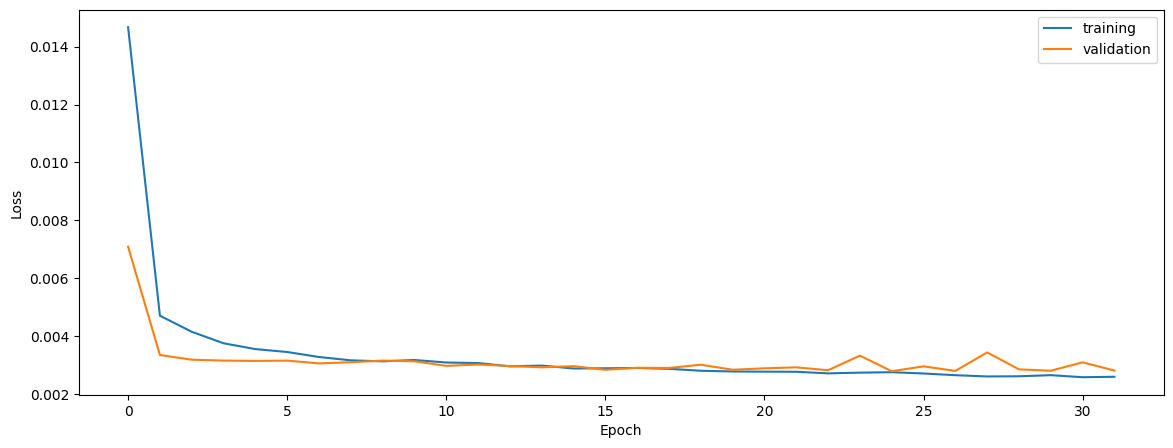

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9000962635131107
0.9022559778200373
0.7809716657934926


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9000962635131107
0.9022559778200373
0.7809716657934926


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9098613782574818
0.9110885623782583
0.7831538113393726


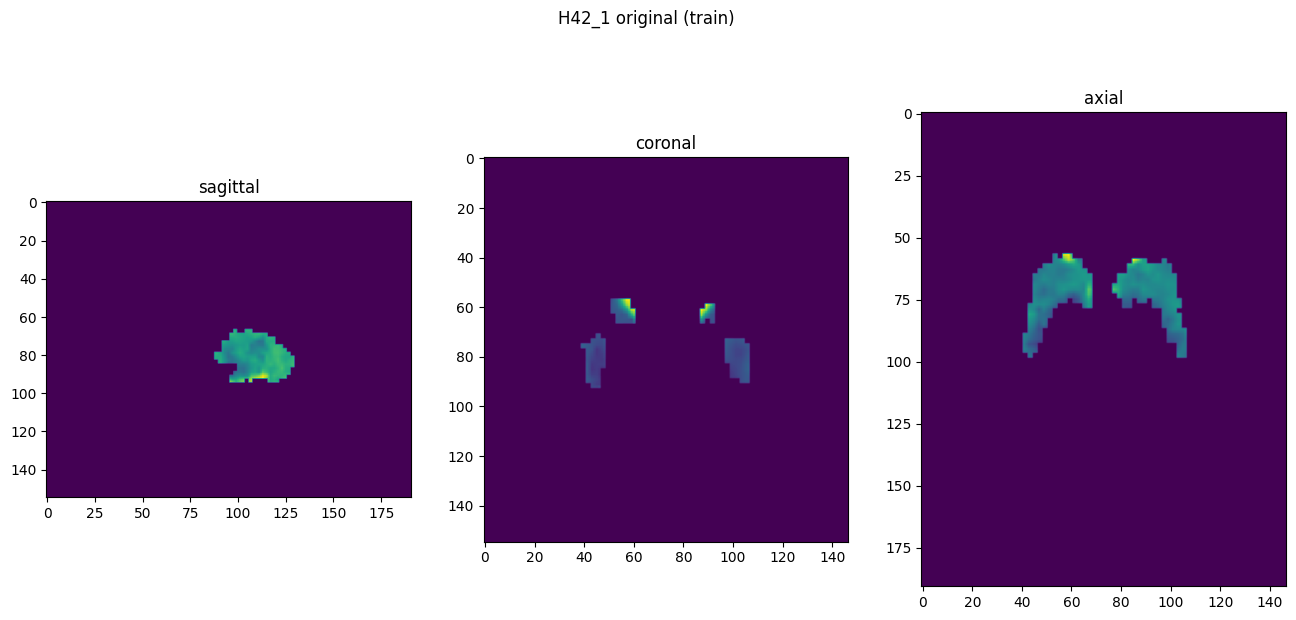

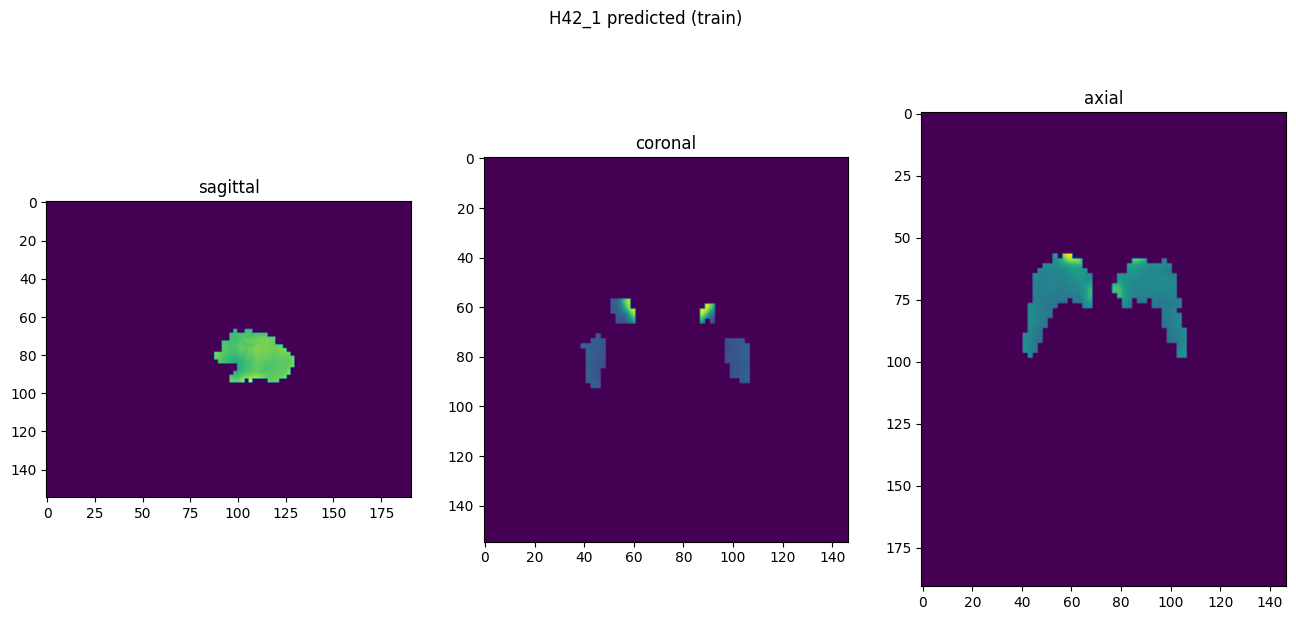

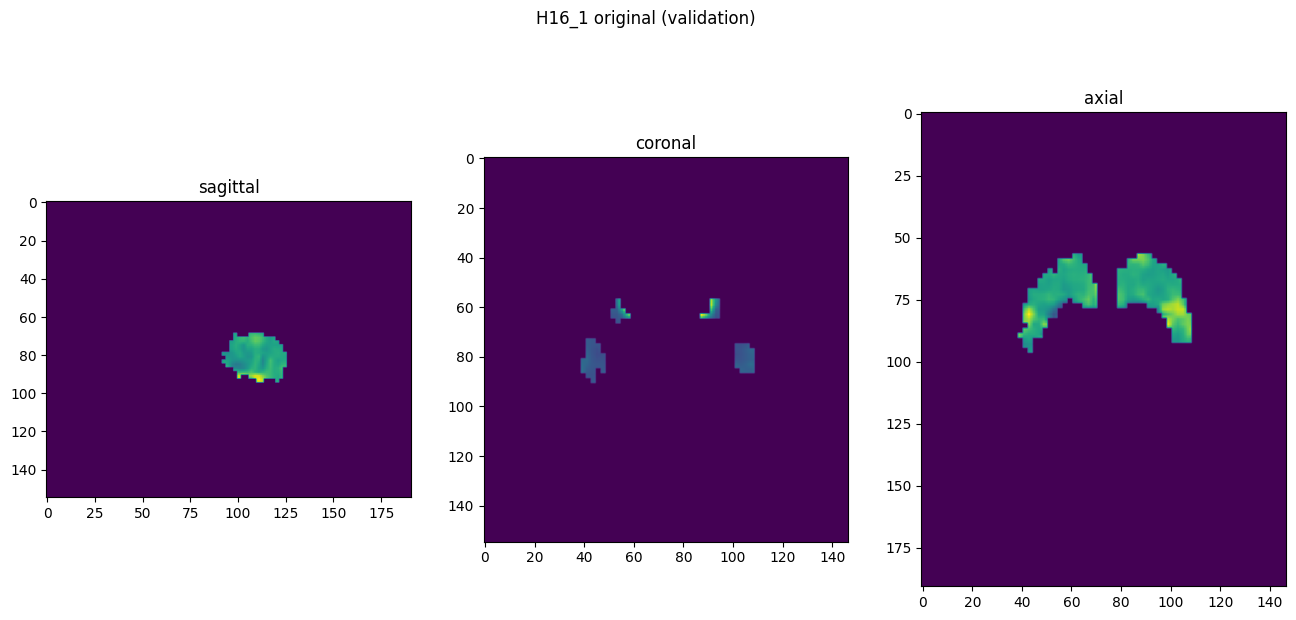

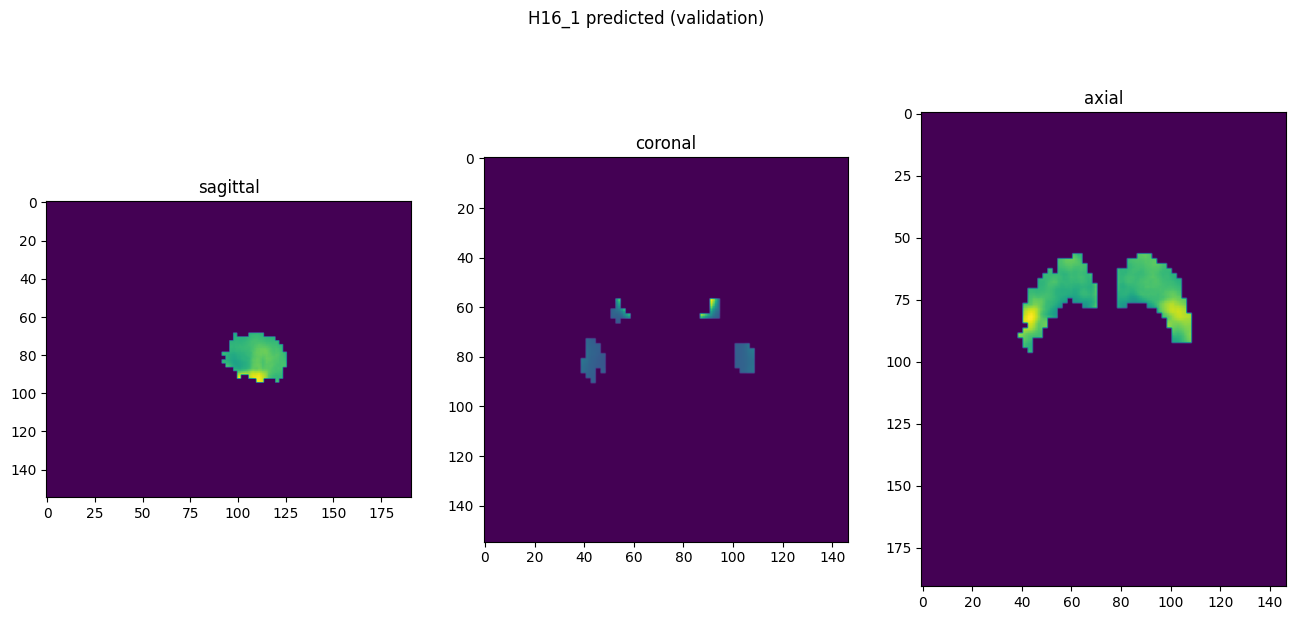

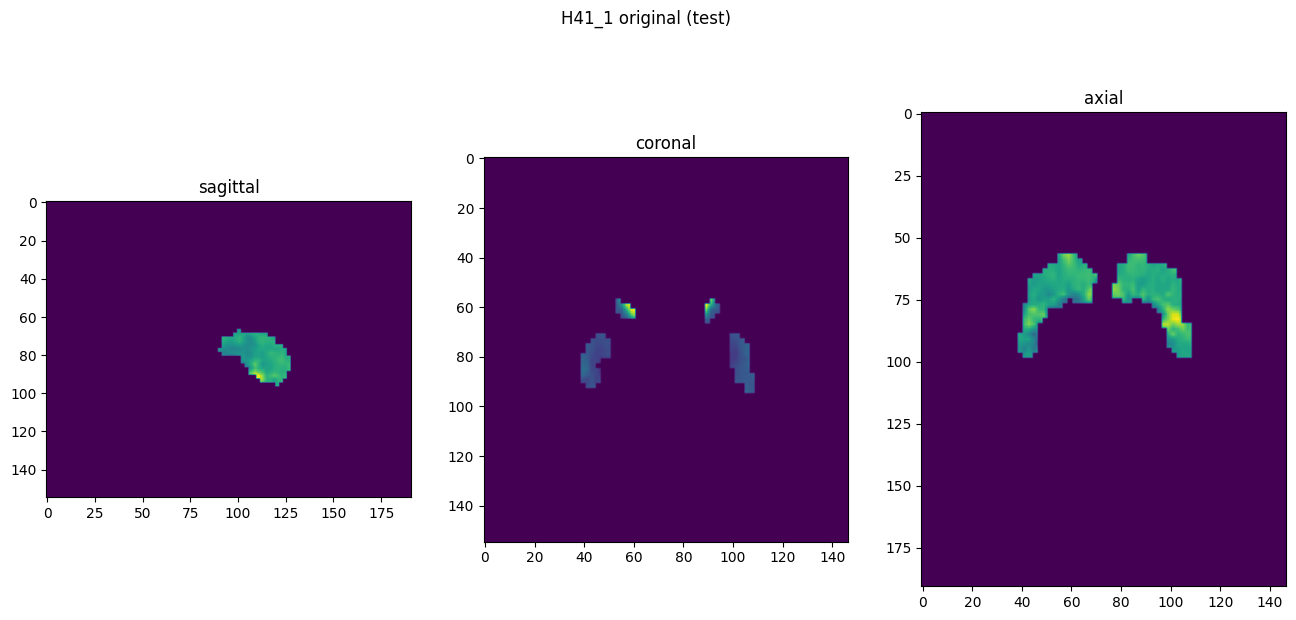

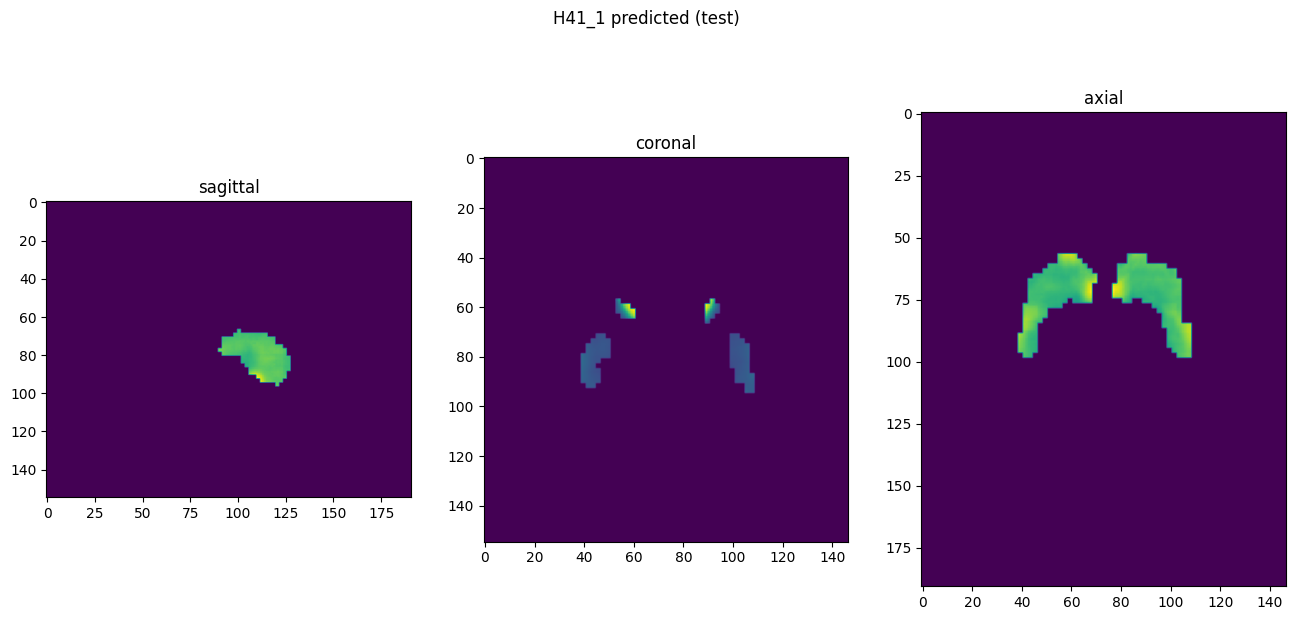

In [10]:
showResults(model, gen, threshold=None, background=False)